**Captchas hacker**

- Connect to Google Drive in order to access dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


 - Importante seleccionar la versión de Tensorflow a 2.x

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.



- Access dataset y creación de las listas de juegos de dastos de entreno y validación


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Definición de rutas
PATH = "/content/drive/My Drive/Colab Notebooks/DotCSV/RetoDotCSV2080Super/Data"
INPATH = PATH + "/samplesRGB"
OUPATH = PATH + "/target"
CKPATH = PATH + "/checkpoints"

# Cargar los ficheros de source utilizando un comando de linux (listar en una columna)
imgurls = !ls -1 "{INPATH}"

# Establecer el tamaño del juego de datos
N = len(imgurls)
train_N = round(N*0.20)
test_N = N-train_N

# En el ejemplo de DotCSV, el juego de datos debe desordenarse para evitar sesgo con el tipo de imagen. El dataset de Captchas no requiere esta función
# aunque la incluimos a modo de referencia para otros problemas y no perjudicará el dataset actual.

# Listado random llamando a la función seed para que sea reproducible en n ejecuciones.
randurls = np.copy(imgurls)
np.random.seed(74)
np.random.shuffle(randurls)

# Particion de los juegos de datos
tr_urls = randurls[:train_N] 
ts_urls = randurls[train_N:N]


- Preparamos el dataset para tener imagenes cuadradas del mismo tamaño. En este caso, no realizaremos data augmentation rotando y trasladando las imagenes.

In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Cambiar el tamaño de una imagen.
# Utilizar un decorador de funcion para activar el modo "compilacion"
@tf.function() 
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

# Normalización de imágenes en el rango [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

# Cargar una imagen
def load(filename, augment = True):
  
  inr = tf.io.read_file(INPATH + "/" + filename)
  rer = tf.io.read_file(OUPATH + "/" + filename)

  injpeg = tf.image.decode_jpeg(inr)
  rejpeg = tf.image.decode_jpeg(rer)
    
  inimg = tf.cast(injpeg, tf.float32)[..., :3]
  reimg = tf.cast(rejpeg, tf.float32)[..., :3]
  
  inimg, reimg = resize(inimg, reimg, IMG_WIDTH, IMG_HEIGHT)
  
  # No se realizará random_jitter en las imágenes
  #if (augment): 
  #  inimg, reimg = random_jitter(inimg, reimg)  
  
  inimg, reimg = normalize(inimg, reimg)

  return inimg, reimg

# Cargar un dataset
def load_train_image(filename):
  return load(filename, True)

def load_test_image(filename):
  return load(filename, False)

- Verificación de las funciones de carga de datos

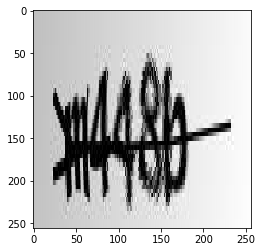

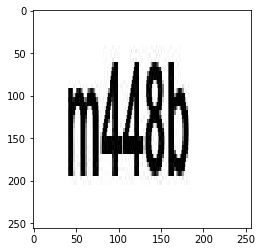

In [5]:
# Cargar una imagen de ejemplo de test set y su resultado
test_filename = randurls[0]
in_fileimg, tg_fileimg = load_test_image(test_filename)

# Pasarlo al rango de 0 a 1
in_fileimg = (in_fileimg + 1) / 2
tg_fileimg = (tg_fileimg + 1) / 2

# Mostrar ambas imagenes
plt.imshow(in_fileimg)
plt.show()
plt.imshow(tg_fileimg)
plt.show()


 - Una vez se dispone de las funciones de carga de datos, se definen los datasets con tensorflow.

In [6]:
# Definir el dataset de entrenamiento y validacion
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1) #El mismo que el paper.

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1) #El mismo que el paper.


 - Construir el generador - Encoder

In [0]:
def downsample(filters, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, kernel_size=4, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=not apply_batchnorm))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

- Construir el generador - Decoder

In [0]:
def upsample(filters, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, kernel_size=4, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


- Ahora que ya están definidas las funciones auxiliares de construir capas down y ap, definimos el generador

In [0]:
def Generator():
  down_stack = [
    downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128),  # (bs, 64, 64, 128)
    downsample(256), # (bs, 32, 32, 256)
    downsample(512), # (bs, 16, 16, 512)
    downsample(512), # (bs, 8, 8, 512)
    downsample(512), # (bs, 4, 4, 512)
    downsample(512), # (bs, 2, 2, 512)
    downsample(512), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512), # (bs, 16, 16, 1024)
    upsample(256), # (bs, 32, 32, 512)
    upsample(128), # (bs, 64, 64, 256)
    upsample(64), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(filters = 3, kernel_size = 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None,None,3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


generator = Generator()

- Despues del generador, construirmos el discriminador

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256)(down2) # (bs, 32, 32, 256)
  down4 = downsample(512)(down3) # (bs, 32, 32, 256)

  last = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(down4) 

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()


- Definimos ls funciones de coste



In [0]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [0]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

- Finalmente, definimos checkpoints para el entrenamiento y llamamos a la función de recuperacion

- Generar imagenes del proceso

In [0]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  
  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + "/output/" + save_filename + ".jpg", prediction[0,...])
  
  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
  plt.show()

In [0]:
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output
import os
import gc

#@tf.function
def train(dataset, epochs):
  
  checkpoint_dir = CKPATH
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
  
  for epoch in range(epochs):
    
    img_index = 0
    for input_image, target in dataset:
      print('epoch: ' + str(epoch) + " - train: " + str(img_index) + "/" + str(len(tr_urls)))
      train_step(input_image, target)
      gc.collect()
      img_index+=1
    
    clear_output(wait=True)
    
    img_index = 0
    for imp, tar in test_dataset.take(5):
      img_index+=1
      generate_images(generator, imp, tar, str(img_index) + "_" + str(epoch), display_imgs=True)
        
    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
   

In [18]:
# Check that we have a GPU instance
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

train(train_dataset,100)

tf.Tensor(
[[[[0.49803925 0.49803925 0.49803925]
   [0.5058824  0.5058824  0.5058824 ]
   [0.5058824  0.5058824  0.5058824 ]
   ...
   [0.9607843  0.9607843  0.9607843 ]
   [0.9607843  0.9607843  0.9607843 ]
   [0.96862745 0.96862745 0.96862745]]

  [[0.49803925 0.49803925 0.49803925]
   [0.5058824  0.5058824  0.5058824 ]
   [0.5058824  0.5058824  0.5058824 ]
   ...
   [0.9607843  0.9607843  0.9607843 ]
   [0.9607843  0.9607843  0.9607843 ]
   [0.96862745 0.96862745 0.96862745]]

  [[0.49803925 0.49803925 0.49803925]
   [0.5058824  0.5058824  0.5058824 ]
   [0.5058824  0.5058824  0.5058824 ]
   ...
   [0.9607843  0.9607843  0.9607843 ]
   [0.9607843  0.9607843  0.9607843 ]
   [0.96862745 0.96862745 0.96862745]]

  ...

  [[0.52156866 0.52156866 0.52156866]
   [0.5294118  0.5294118  0.5294118 ]
   [0.5294118  0.5294118  0.5294118 ]
   ...
   [0.9843137  0.9843137  0.9843137 ]
   [0.9843137  0.9843137  0.9843137 ]
   [0.99215686 0.99215686 0.99215686]]

  [[0.52156866 0.52156866 0.521568

In [19]:
import os

checkpoint_dir = CKPATH
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

KeyboardInterrupt: ignored